In [5]:
from google.colab import files

# Upload the ZIP file (you'll be prompted to select it)
uploaded = files.upload()

Saving archive.zip to archive.zip


In [46]:
# step 0: Setup & Extraction
import zipfile, os

zip_path = list(uploaded.keys())[0]  # assuming you uploaded the zip
extract_dir = "/content/legalclausedataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Extracted to:", extract_dir)
print("Total files:", len(os.listdir(extract_dir)))
print(os.listdir(extract_dir)[:10])

✅ Extracted to: /content/legalclausedataset
Total files: 395
['organization.csv', 'independent-contractor.csv', 'registration-rights.csv', 'amendments-and-waivers.csv', 'term-of-employment.csv', 'indebtedness.csv', 'transfer.csv', 'now-therefore.csv', 'time.csv', 'r-e-c-i-t-a-l-s.csv']


In [25]:
# step 1: Project setup & imports
import os, glob, random, re
from itertools import combinations
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DATA_DIR = "/content/legalclausedataset"
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [26]:
# step 2: Load CSV files into dataframe
def detect_text_column(df):
    candidates = ['text','clause_text','clause','content','sentence','excerpt']
    for c in candidates:
        if c in df.columns:
            return c
    for c in df.columns:
        if df[c].dtype == 'object':
            return c
    return df.columns[0]

def load_all_csvs(data_dir):
    paths = glob.glob(os.path.join(data_dir, "*.csv"))
    rows = []
    for p in paths:
        name = os.path.splitext(os.path.basename(p))[0]
        try:
            df = pd.read_csv(p, dtype=str)
        except Exception as e:
            print(f"Error reading {p}: {e}")
            continue
        col = detect_text_column(df)
        texts = df[col].fillna('').astype(str).tolist()
        for i, t in enumerate(texts):
            t = t.strip()
            if t == "": continue
            clause_id = f"{name}_{i}"
            rows.append({'clause_id': clause_id, 'category': name, 'text': t})
    return pd.DataFrame(rows)

df_clauses = load_all_csvs(DATA_DIR)
print("Total clauses loaded:", len(df_clauses))
df_clauses.head(5)

Total clauses loaded: 150881


,clause_id,category,text
0,organization_0,organization,Organization. Buyer is a corporation duly orga...
1,organization_1,organization,Organization. Buyer is a corporation duly orga...
2,organization_2,organization,Organization. The Company and each of its Subs...
3,organization_3,organization,Organization. The Company is a corporation dul...
4,organization_4,organization,Organization. ZiaSun is a corporation duly org...


           num_chars     num_tokens
count  150881.000000  150881.000000
mean      597.034285      95.184821
std       547.542085      87.570238
min        13.000000       2.000000
25%       216.000000      34.000000
50%       413.000000      66.000000
75%       777.000000     125.000000
max      2550.000000    1028.000000
Top categories
 category
time-of-essence                          630
time-of-the-essence                      620
definitions-and-interpretation           590
capitalized-terms                        590
captions                                 580
headings                                 570
exhibits                                 570
section-headings                         570
now-therefore                            570
definitions                              560
financial-covenants                      560
defined-terms                            560
certain-defined-terms                    550
covenants-of-the-company                 540
name                 

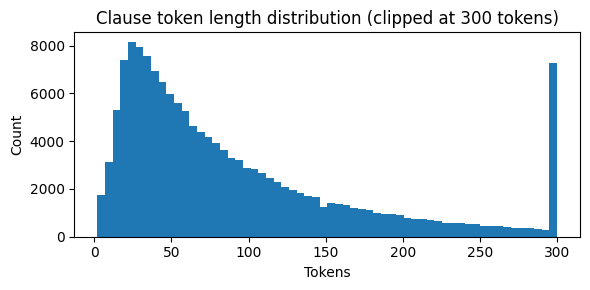

In [27]:
# step 3: EDA
df_clauses['num_chars'] = df_clauses['text'].apply(len)
df_clauses['num_tokens'] = df_clauses['text'].apply(lambda s: len(s.split()))
print(df_clauses[['num_chars','num_tokens']].describe())

cat_counts = df_clauses['category'].value_counts().head(20)
print("Top categories\n", cat_counts)

plt.figure(figsize=(6,3))
plt.hist(df_clauses['num_tokens'].clip(0,300), bins=60)
plt.title("Clause token length distribution (clipped at 300 tokens)")
plt.xlabel("Tokens")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [28]:
# step 4: Data Augmentation Functions
# Synonym replacement using WordNet
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

def synonym_replace(sentence, p=0.05):
    words = sentence.split()
    new_words = []
    for w in words:
        if random.random() < p:
            syns = wordnet.synsets(w)
            if syns:
                lemmas = [l.name() for l in syns[0].lemmas() if "_" not in l.name()]
                if lemmas:
                    w = random.choice(lemmas)
        new_words.append(w)
    return " ".join(new_words)

# Apply augmentation with some probability
def augment_text(text, p=0.3):
    if random.random() < p:
        text = synonym_replace(text, p=0.05)
    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [29]:
# step 5: Generate positive and negative pairs (with hard negatives)
MAX_POS_PER_CAT = 200
NEG_RATIO = 1

# Example similar categories for hard negatives
similar_cats = {
    "payment_terms": ["additional_documents", "definitions"],
    "access-to-information": ["confidentiality", "reporting"]
}

def generate_pairs_aug(df_clauses, n_pos_per_cat=MAX_POS_PER_CAT, neg_ratio=NEG_RATIO, seed=SEED):
    random.seed(seed)
    pairs = []

    # positives: within same category
    for cat, g in df_clauses.groupby('category'):
        ids = g['clause_id'].tolist()
        if len(ids) < 2: continue
        all_combos = list(combinations(ids, 2))
        random.shuffle(all_combos)
        take = min(n_pos_per_cat, len(all_combos))
        for a,b in all_combos[:take]:
            pairs.append((a,b,1))
            # augment both sides slightly
            a_text, b_text = g.set_index('clause_id')['text'][a], g.set_index('clause_id')['text'][b]
            pairs.append((a, b, 1))  # optionally keep augmented separately

    # negatives: hard negatives from similar categories, else random
    pos_count = sum(1 for _ in pairs)
    neg_needed = pos_count * neg_ratio
    cat_to_ids = {cat: g['clause_id'].tolist() for cat,g in df_clauses.groupby('category')}
    cat_list = list(cat_to_ids.keys())
    negs = set()
    tries = 0
    while len(negs) < neg_needed and tries < neg_needed*20:
        c1 = random.choice(cat_list)
        # hard negative
        c2_candidates = similar_cats.get(c1, [x for x in cat_list if x != c1])
        c2 = random.choice(c2_candidates)
        a = random.choice(cat_to_ids[c1])
        b = random.choice(cat_to_ids[c2])
        pair = tuple(sorted((a,b)))
        if pair in negs:
            tries += 1
            continue
        negs.add(pair)
    for a,b in negs:
        pairs.append((a,b,0))

    pairs_df = pd.DataFrame(pairs, columns=['id_a','id_b','label'])
    id2text = df_clauses.set_index('clause_id')['text'].to_dict()
    pairs_df['text_a'] = pairs_df['id_a'].map(id2text)
    pairs_df['text_b'] = pairs_df['id_b'].map(id2text)
    pairs_df = pairs_df.dropna().reset_index(drop=True)
    return pairs_df

pairs_df = generate_pairs_aug(df_clauses)
print("Total pairs created:", len(pairs_df))
pairs_df.head()

Total pairs created: 315620


,id_a,id_b,label,text_a,text_b
0,absence-of-certain-changes_238,absence-of-certain-changes_340,1,Absence of Certain Changes. Except as disclose...,"Absence of Certain Changes. (a) Since June 30,..."
1,absence-of-certain-changes_238,absence-of-certain-changes_340,1,Absence of Certain Changes. Except as disclose...,"Absence of Certain Changes. (a) Since June 30,..."
2,absence-of-certain-changes_101,absence-of-certain-changes_219,1,Absence of Certain Changes. Since the Balance ...,Absence of Certain Changes. (a) Since March 31...
3,absence-of-certain-changes_101,absence-of-certain-changes_219,1,Absence of Certain Changes. Since the Balance ...,Absence of Certain Changes. (a) Since March 31...
4,absence-of-certain-changes_10,absence-of-certain-changes_99,1,Absence of Certain Changes. Except as disclose...,Absence of Certain Changes. Since the date of ...


In [30]:
# step 6: Safe train/val/test split
unique_ids = df_clauses['clause_id'].unique().tolist()
train_ids, rest_ids = train_test_split(unique_ids, test_size=0.3, random_state=SEED)
val_ids, test_ids = train_test_split(rest_ids, test_size=0.5, random_state=SEED)

def filter_pairs_by_ids(pairs_df, id_set):
    return pairs_df[pairs_df['id_a'].isin(id_set) & pairs_df['id_b'].isin(id_set)].reset_index(drop=True)

train_pairs = filter_pairs_by_ids(pairs_df, set(train_ids))
val_pairs   = filter_pairs_by_ids(pairs_df, set(val_ids))
test_pairs  = filter_pairs_by_ids(pairs_df, set(test_ids))

print("Pairs split -> Train:", len(train_pairs), "Val:", len(val_pairs), "Test:", len(test_pairs))

train_pairs.to_csv(os.path.join(OUTPUT_DIR, "train_pairs.csv"), index=False)
val_pairs.to_csv(os.path.join(OUTPUT_DIR, "val_pairs.csv"), index=False)
test_pairs.to_csv(os.path.join(OUTPUT_DIR, "test_pairs.csv"), index=False)

Pairs split -> Train: 154621 Val: 7126 Test: 7080


In [31]:
# step 7: Preprocessing + Vocabulary
def simple_clean(s):
    s = str(s).strip()
    s = re.sub(r'\s+', ' ', s)
    return s.lower()

for df in [train_pairs, val_pairs, test_pairs]:
    df['text_a'] = df['text_a'].apply(simple_clean)
    df['text_b'] = df['text_b'].apply(simple_clean)

def build_vocab_from_texts(texts, max_vocab=30000, min_freq=2):
    cnt = Counter()
    for t in texts:
        for w in t.split(): cnt[w]+=1
    tokens = [w for w,f in cnt.most_common(max_vocab) if f >= min_freq]
    stoi = {'<pad>':0, '<unk>':1}
    for i, tok in enumerate(tokens, start=2):
        stoi[tok] = i
    return stoi

all_train_texts = pd.concat([train_pairs['text_a'], train_pairs['text_b']])
STOI = build_vocab_from_texts(all_train_texts.tolist(), max_vocab=30000, min_freq=2)
print("Vocab size:", len(STOI))

Vocab size: 30002


In [32]:
# step 8: Encode & Pad
MAX_LEN = 256  # increased from 128

def encode_text(s, stoi=STOI, max_len=MAX_LEN):
    toks = s.split()[:max_len]
    ids = [stoi.get(w, stoi['<unk>']) for w in toks]
    if len(ids) < max_len:
        ids += [stoi['<pad>']] * (max_len - len(ids))
    return ids

print("Example encoding length:", len(encode_text(train_pairs.loc[0,'text_a'])))

Example encoding length: 256


In [33]:
# step 9: PyTorch Dataset
class ClausePairDataset(Dataset):
    def __init__(self, df, stoi, max_len=MAX_LEN, augment=False):
        self.df = df.reset_index(drop=True)
        self.stoi = stoi
        self.max_len = max_len
        self.augment = augment
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        a_text, b_text = r['text_a'], r['text_b']
        if self.augment:
            a_text = augment_text(a_text)
            b_text = augment_text(b_text)
        a = torch.tensor(encode_text(a_text, self.stoi, self.max_len), dtype=torch.long)
        b = torch.tensor(encode_text(b_text, self.stoi, self.max_len), dtype=torch.long)
        y = torch.tensor(r['label'], dtype=torch.float)
        return a, b, y

BATCH_SIZE = 16  # smaller for better generalization
train_ds = ClausePairDataset(train_pairs, STOI, MAX_LEN, augment=True)
val_ds   = ClausePairDataset(val_pairs, STOI, MAX_LEN, augment=False)
test_ds  = ClausePairDataset(test_pairs, STOI, MAX_LEN, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [34]:
# step 10: Siamese BiLSTM (Regularized)
class BiLSTMSiamese(nn.Module):
    def __init__(self, vocab_size, emb_dim=200, hidden_size=128, n_layers=1, dropout=0.5, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.encoder = nn.LSTM(
            emb_dim,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if n_layers>1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        encoded_dim = hidden_size * 4  # mean+max pooling
        combined_dim = encoded_dim * 4  # [u,v,|u-v|,u*v]

        self.fc = nn.Sequential(
            nn.Linear(combined_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128,1)
        )

    def encode(self, x):
        emb = self.embedding(x)
        out, _ = self.encoder(emb)
        mean_pooled = out.mean(dim=1)
        max_pooled,_ = out.max(dim=1)
        return torch.cat([mean_pooled,max_pooled], dim=1)

    def forward(self, a, b):
        ua = self.encode(a)
        ub = self.encode(b)
        diff = torch.abs(ua-ub)
        prod = ua*ub
        x = torch.cat([ua,ub,diff,prod], dim=1)
        logits = self.fc(x).squeeze(1)
        return logits

model_a = BiLSTMSiamese(
    vocab_size=len(STOI),
    emb_dim=200,
    hidden_size=128,
    n_layers=1,
    dropout=0.5,
    pad_idx=STOI["<pad>"]
).to(DEVICE)

print("Model A parameters:", sum(p.numel() for p in model_a.parameters() if p.requires_grad))

Model A parameters: 7453201


In [35]:
# step 11: BiLSTM + Attention
class AttentionEncoder(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.proj = nn.Linear(hidden_size*2, hidden_size*2)
        self.context = nn.Parameter(torch.randn(hidden_size*2))

    def forward(self, outputs, mask=None):
        u = torch.tanh(self.proj(outputs))
        scores = torch.matmul(u, self.context)  # (B,L)
        if mask is not None:
            scores = scores.masked_fill(mask==0, -1e9)
        attn = torch.softmax(scores, dim=1).unsqueeze(2)
        rep = (outputs*attn).sum(dim=1)
        return rep

class BiLSTMAttentionSiamese(nn.Module):
    def __init__(self, vocab_size, emb_dim=200, hidden_size=128, n_layers=1, dropout=0.5, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.encoder = nn.LSTM(
            emb_dim, hidden_size, num_layers=n_layers,
            batch_first=True, bidirectional=True,
            dropout=dropout if n_layers>1 else 0.0
        )
        self.att = AttentionEncoder(hidden_size)
        self.dropout = nn.Dropout(dropout)
        encoded_dim = hidden_size*2  # attention
        combined_dim = encoded_dim*4

        self.fc = nn.Sequential(
            nn.Linear(combined_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64,1)
        )

    def encode(self, x):
        emb = self.embedding(x)
        out,_ = self.encoder(emb)
        rep = self.att(out)
        return rep

    def forward(self, a,b):
        ua = self.encode(a)
        ub = self.encode(b)
        diff = torch.abs(ua-ub)
        prod = ua*ub
        x = torch.cat([ua,ub,diff,prod], dim=1)
        logits = self.fc(x).squeeze(1)
        return logits

model_b = BiLSTMAttentionSiamese(
    vocab_size=len(STOI),
    emb_dim=200,
    hidden_size=128,
    n_layers=1,
    dropout=0.5,
    pad_idx=STOI["<pad>"]
).to(DEVICE)

print("Model B parameters:", sum(p.numel() for p in model_b.parameters() if p.requires_grad))

Model B parameters: 6683281


In [36]:
# step 12: Metrics
def compute_metrics(y_true, y_probs, thr=0.5):
    y_pred = (y_probs>=thr).astype(int)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_probs) if len(np.unique(y_true))>1 else np.nan,
        "pr_auc": average_precision_score(y_true, y_probs) if len(np.unique(y_true))>1 else np.nan
    }

def eval_model(model, dataloader, device=DEVICE):
    model.eval()
    probs, labels = [], []
    with torch.no_grad():
        for a,b,y in dataloader:
            a,b = a.to(device), b.to(device)
            logits = model(a,b)
            p = torch.sigmoid(logits).cpu().numpy()
            probs.extend(p)
            labels.extend(y.numpy())
    return compute_metrics(np.array(labels), np.array(probs)), np.array(labels), np.array(probs)

In [37]:
# step 13: Training Loop with Gradient Clipping & Early Stopping
def train_model(model, train_loader, val_loader, n_epochs=15, lr=1e-3, weight_decay=1e-5, save_path=None, patience=3):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.BCEWithLogitsLoss()
    best_f1, wait = -1, 0
    hist = {"train_loss":[],"val_f1":[]}

    for epoch in range(1,n_epochs+1):
        model.train()
        total=0
        for a,b,y in train_loader:
            a,b,y = a.to(DEVICE),b.to(DEVICE),y.to(DEVICE)
            opt.zero_grad()
            logits = model(a,b)
            loss = loss_fn(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # gradient clipping
            opt.step()
            total += loss.item() * a.size(0)
        train_loss = total / len(train_loader.dataset)
        val_metrics, _, _ = eval_model(model,val_loader)
        val_f1 = val_metrics["f1"]
        hist["train_loss"].append(train_loss)
        hist["val_f1"].append(val_f1)
        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val F1: {val_f1:.4f}")
        # early stopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            wait = 0
            if save_path:
                torch.save(model.state_dict(), save_path)
                print(f"  → Saved best model (f1={best_f1:.4f})")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered!")
                break
    return hist

Epoch 01 | Train Loss: 0.0388 | Val F1: 0.9951
  → Saved best model (f1=0.9951)
Epoch 02 | Train Loss: 0.0146 | Val F1: 0.9966
  → Saved best model (f1=0.9966)
Epoch 03 | Train Loss: 0.0114 | Val F1: 0.9976
  → Saved best model (f1=0.9976)
Epoch 04 | Train Loss: 0.0103 | Val F1: 0.9970
Epoch 05 | Train Loss: 0.0104 | Val F1: 0.9983
  → Saved best model (f1=0.9983)
Epoch 06 | Train Loss: 0.0095 | Val F1: 0.9980
Epoch 07 | Train Loss: 0.0092 | Val F1: 0.9967
Epoch 08 | Train Loss: 0.0095 | Val F1: 0.9974
Early stopping triggered!


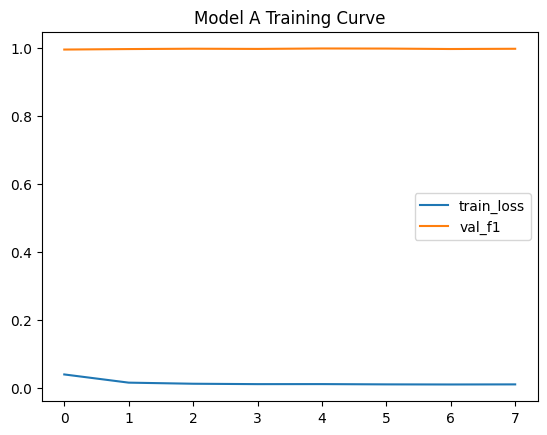

Model A Test Metrics: {'accuracy': 0.9966101694915255, 'precision': 0.9988839285714286, 'recall': 0.9944444444444445, 'f1': 0.9966592427616926, 'roc_auc': np.float64(0.9997723499361431), 'pr_auc': np.float64(0.9997937785116493)}


In [38]:
# step 14: Train & Evaluate Models
# Model A
SAVE_A = os.path.join(OUTPUT_DIR, "model_siamese_bilstm.pth")
history_a = train_model(model_a, train_loader, val_loader, n_epochs=15, lr=1e-3, save_path=SAVE_A)

plt.plot(history_a["train_loss"], label="train_loss")
plt.plot(history_a["val_f1"], label="val_f1")
plt.legend(); plt.title("Model A Training Curve"); plt.show()

model_a.load_state_dict(torch.load(SAVE_A,map_location=DEVICE))
metrics_a, y_true_a, y_prob_a = eval_model(model_a,test_loader)
print("Model A Test Metrics:", metrics_a)

Epoch 01 | Train Loss: 0.0889 | Val F1: 0.9948
  → Saved best model (f1=0.9948)
Epoch 02 | Train Loss: 0.0113 | Val F1: 0.9973
  → Saved best model (f1=0.9973)
Epoch 03 | Train Loss: 0.0199 | Val F1: 0.9986
  → Saved best model (f1=0.9986)
Epoch 04 | Train Loss: 0.0064 | Val F1: 0.9977
Epoch 05 | Train Loss: 0.0064 | Val F1: 0.9970
Epoch 06 | Train Loss: 0.0069 | Val F1: 0.9977
Early stopping triggered!


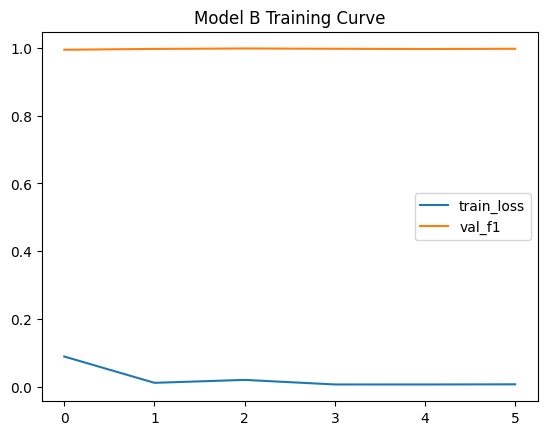

Model B Test Metrics: {'accuracy': 0.9971751412429378, 'precision': 0.9983296213808464, 'recall': 0.9961111111111111, 'f1': 0.9972191323692993, 'roc_auc': np.float64(0.99997812899106), 'pr_auc': np.float64(0.999979001182272)}


In [39]:
# step 14: Train & Evaluate Models
# Model B
SAVE_B = os.path.join(OUTPUT_DIR, "model_bilstm_attention.pth")
history_b = train_model(model_b, train_loader, val_loader, n_epochs=15, lr=1e-3, save_path=SAVE_B)

plt.plot(history_b["train_loss"], label="train_loss")
plt.plot(history_b["val_f1"], label="val_f1")
plt.legend(); plt.title("Model B Training Curve"); plt.show()

model_b.load_state_dict(torch.load(SAVE_B,map_location=DEVICE))
metrics_b, y_true_b, y_prob_b = eval_model(model_b,test_loader)
print("Model B Test Metrics:", metrics_b)

In [44]:
# step 15: Comparative Results
results = pd.DataFrame([
    {"Model":"Siamese BiLSTM", **metrics_a},
    {"Model":"BiLSTM + Attention", **metrics_b}
])
results.to_csv(os.path.join(OUTPUT_DIR,"model_comparison_aug.csv"), index=False)
print(results)

                Model  accuracy  precision    recall        f1   roc_auc  \
0      Siamese BiLSTM  0.996610   0.998884  0.994444  0.996659  0.999772   
1  BiLSTM + Attention  0.997175   0.998330  0.996111  0.997219  0.999978   

     pr_auc  
0  0.999794  
1  0.999979  
